## 1. Import packges

In [22]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## 2. Load dataset

In [23]:
with open('mod_05_topic_10_various_data.pkl', 'rb') as f:
    datasets = pickle.load(f)

autos = datasets['autos']
autos.head()

,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


## 3. Define discrete features

In [24]:
discrete_features = [
    'make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels',
    'engine_location', 'engine_type', 'fuel_system', 'num_of_doors', 'num_of_cylinders'
]

## 4. Calculate mutual information

In [25]:
from sklearn.preprocessing import LabelEncoder

autos_encoded = autos.copy()

for col in discrete_features:
    le = LabelEncoder()
    autos_encoded[col] = le.fit_transform(autos[col])

X = autos_encoded.drop(columns=['price'])
y = autos_encoded['price']

mi_scores = mutual_info_regression(
    X, y, 
    discrete_features=X.columns.isin(discrete_features), 
    random_state=42
)

mi_scores_df = pd.DataFrame({
    'Feature': X.columns, 
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

mi_scores_df

,Feature,MI_Score
11,curb_weight,0.911713
14,engine_size,0.900925
19,horsepower,0.891165
22,highway_mpg,0.887362
21,city_mpg,0.774127
9,width,0.679991
8,length,0.612483
7,wheel_base,0.588635
0,make,0.543268
16,bore,0.497420


## 5. Build regression model for feature importance

In [26]:
categorical_cols = [
    'make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels',
    'engine_location', 'engine_type', 'fuel_system', 'num_of_doors', 'num_of_cylinders'
]
numeric_cols = [col for col in autos.columns if col not in categorical_cols + ['price']]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

X_train = autos.drop(columns=['price'])
y_train = autos['price']

model.fit(X_train, y_train)

feature_names = (
    model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_cols).tolist() + 
    numeric_cols
)

importances = model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

,Feature,Importance
50,engine_size,0.639995
49,curb_weight,0.167876
54,horsepower,0.050945
57,highway_mpg,0.039819
47,width,0.016395
46,length,0.014643
45,wheel_base,0.014229
56,city_mpg,0.010323
1,make_bmw,0.008932
51,bore,0.006225


## 6. Normalize scores using rank

In [27]:
importance_agg = {}
for col in categorical_cols:
    related = [f for f in feature_importance_df['Feature'] if f.startswith(col)]
    if related:
        importance_agg[col] = feature_importance_df[
            feature_importance_df['Feature'].isin(related)
        ]['Importance'].sum()

for col in numeric_cols:
    importance_agg[col] = feature_importance_df[
        feature_importance_df['Feature'] == col
    ]['Importance'].values[0]

importance_agg_df = pd.DataFrame(
    list(importance_agg.items()), 
    columns=['Feature', 'Importance']
)

mi_scores_df['MI_Rank'] = mi_scores_df['MI_Score'].rank(pct=True)
importance_agg_df['Importance_Rank'] = importance_agg_df['Importance'].rank(pct=True)

comparison_df = mi_scores_df[['Feature', 'MI_Rank']].merge(
    importance_agg_df[['Feature', 'Importance_Rank']], 
    on='Feature'
)

comparison_df

,Feature,MI_Rank,Importance_Rank
0,curb_weight,1.000000,0.956522
1,engine_size,0.956522,1.000000
2,horsepower,0.913043,0.913043
3,highway_mpg,0.869565,0.869565
4,city_mpg,0.826087,0.652174
5,width,0.782609,0.826087
6,length,0.739130,0.782609
7,wheel_base,0.695652,0.739130
8,make,0.652174,0.695652
9,bore,0.608696,0.608696


## 7. Visualization with grouped barplot

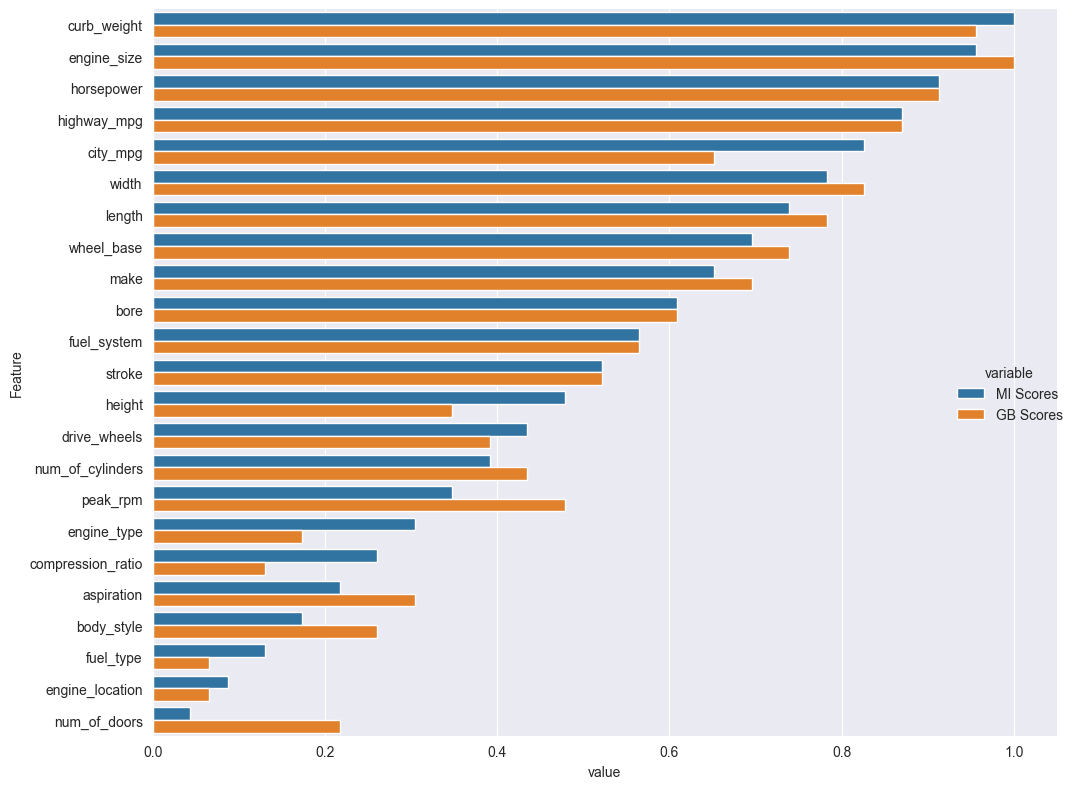

In [28]:
melted_df = pd.melt(
    comparison_df, 
    id_vars=['Feature'], 
    value_vars=['MI_Rank', 'Importance_Rank'],
    var_name='variable', 
    value_name='value'
)

melted_df['variable'] = melted_df['variable'].replace({
    'MI_Rank': 'MI Scores',
    'Importance_Rank': 'GB Scores'
})

feature_order = comparison_df.sort_values('MI_Rank', ascending=False)['Feature'].tolist()

g = sns.catplot(
    data=melted_df,
    x='value',
    y='Feature',
    hue='variable',
    kind='bar',
    order=feature_order,
    height=8,
    aspect=1.2
)
plt.tight_layout()
plt.show()

##  Conclusions

Features with high values in both MI_Rank and Importance_Rank (such as curb_weight, engine_size, horsepower) have the strongest impact on predicting car prices. These characteristics are key factors for the model.

Some features show discrepancies between mutual information and model importance. Features with low values in both metrics (like num_of_doors, engine_location) have weak connections to price and could be candidates for removal in model optimization.

The difference between MI scores and feature importance from Gradient Boosting reveals that mutual information captures linear relationships, while tree-based importance captures non-linear interactions used in decision-making.